PROJET TER - CLASSIFICATION DE TEXTES TRADUITS - APPROCHE NAÏVE ET VECTORIELLE

In [1]:
#Imports nécessaire
import numpy as np
from sklearn import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import time as time
import pandas as pd
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import *
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import *
from scipy.stats import *
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.under_sampling import RandomUnderSampler, NearMiss
import re

In [2]:
#Recuperation des données textuelles à partir des dossiers contenant les livres sous format .txt
corpus=[]

path =r'./txtT'
liste_fichiers = []

for root, dirs, files in os.walk(path):
	for file in files:
		liste_fichiers.append(os.path.join(root,file).replace('\\','/'))

path =r'./txtO'
n_traduit=  len(liste_fichiers)

for root, dirs, files in os.walk(path):
	for file in files:
		liste_fichiers.append(os.path.join(root,file).replace('\\','/'))

print("Les dossiers contiennent " , len(liste_fichiers), " fichiers")

for fichier in liste_fichiers:
    #book = open_book(fichier)
    #lines = convert_epub_to_lines(book)
    #suppressionCode = re.compile(r'<.*?>')
    with open(fichier, 'r',encoding='utf-8') as nom_fich:
        try:
            texte_nettoye =  "".join(nom_fich.readlines()).replace("*","").replace("\n"," ").replace("—"," ").lower()
            corpus.append((fichier.split("/")[-1][:-4], texte_nettoye))
        except:
            print("Ce texte ne peut pas etre utilise : ", fichier.split("/")[-1][:-4])
    if fichier == liste_fichiers[n_traduit]:
        n_traduit = len(corpus)-1


print("Le corpus est composé de " , len(corpus), " textes")

 le tiotuti fichier  1702  fichiers
le problz est :  La Chambre des officiers - Dugain, Marc
 le corpus fait  1701  textes


Approche "naïve" 

In [3]:
#Extraction de caractéristique "naïve" du texte - maintenant mesure relative et non absolue

def delimitation_mot(texte):
    return re.split("[’ \-']", texte.replace('\n',' ').replace('.', ' '))

def delimitation_phrase(texte):
    return re.split("\.", texte.replace("\n", ' '))

# Transforme le texte en dictionnaire où chaque mot unique est associé à son nombre d'apparitions 
def text_to_freq(mots_texte):
    dico = {}
    dico["max"] = 1
    liste_mots = delimitation_mot(mots_texte)
    for mot in liste_mots:
        if mot in dico.keys():
            dico[mot]+=1
            if(dico[mot]>dico["max"]):
                dico["max"]=dico[mot]
        else:
            dico[mot]=1
    return (dico, len(liste_mots), liste_mots)

def nombre_mots(dicoTexte, taille):
    return len(dicoTexte.keys())/taille

def nombre_mots_rare(dicoTexte,taille):
    c=0
    for k in dicoTexte.keys():
        if dicoTexte[k]<5:
            c+=1
    return c/taille

def nombre_mots_frequent(dicoTexte,taille):
    c=0
    for k in dicoTexte.keys():
        if dicoTexte[k] >250:
            c+=1
    return c/taille


tt = text_to_freq(corpus[0][0])

l=[]
for texte in corpus:
    dico, taille, listeMots = text_to_freq(texte[1])
    l.append( (nombre_mots(dico, taille), nombre_mots_frequent(dico,taille), nombre_mots_rare(dico,taille), dico["max"]/taille , len(dico.keys())/len(listeMots) ))


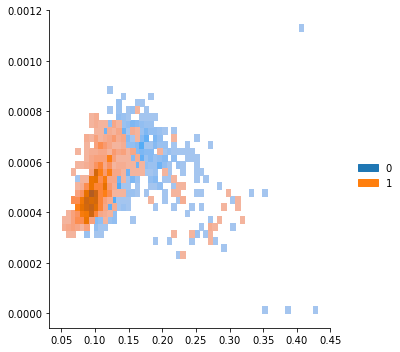

In [29]:
import seaborn as sns

data = np.array(l)
data_labels = [1]*n_traduit + [0]*(len(corpus)-n_traduit)
sns.displot(x=data[:,4], y=data[:,1], hue=data_labels)

In [36]:
#Modèle naïf : SVM avec les paramètres par défaut 

X_train, X_test, y_train, y_test = train_test_split(data, data_labels,test_size=0.2)

grid_naif = GridSearchCV(SVC(), {})

grid_naif.fit(X_train, y_train)
ypred = grid_naif.best_estimator_.predict(X_test)

print(grid_naif.best_estimator_.score(X_test,y_test))
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

modele_utilisable_naif = grid_naif.best_estimator_

0.7360703812316716
[[149  31]
 [ 59 102]]
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       180
           1       0.77      0.63      0.69       161

    accuracy                           0.74       341
   macro avg       0.74      0.73      0.73       341
weighted avg       0.74      0.74      0.73       341



Approche vectorielle

In [8]:
#Recuperation du texte pour chaque livre et separation entre traduit et natif

livreTrad = [livre[1] for livre in corpus[:n_traduit]]
livreOrig = [livre[1] for livre in corpus[n_traduit:]]

In [9]:
# Découpage du corpus en morceaux de taille arbitraires par catégorie
livreOriginal = " ".join(livreOrig)
corpusOrig = np.array([])
taille = len(livreOriginal)
pas = 250000
n=0
print(taille)
while(n<taille):
    corpusOrig = np.append(corpusOrig, livreOriginal[n:n+pas])
    n+=pas
print(corpusOrig.shape)

461575993
(1847,)


In [10]:
livreTraduit = " ".join(livreTrad)
corpusTrad = np.array([])
taille = len(livreTraduit)
n=0
print(taille)
while(n<taille):
    corpusTrad = np.append(corpusTrad, livreTraduit[n:n+pas])
    n+=pas
print(corpusTrad.shape)

501408637
(2006,)


In [11]:
#Mise en forme des données et des labels pour l'apprentissage machine
features= np.concatenate((corpusTrad, corpusOrig), axis=0)
labels = [1]*corpusTrad.shape[0] + [0]*corpusOrig.shape[0]

In [24]:
#Modèle fonctionnel : CountVectorizer suivi de MultinomialNB avec les paramètres par défaut 
X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.2)

modele = make_pipeline(CountVectorizer(), MultinomialNB())
grid = GridSearchCV(modele, {})

grid.fit(X_train, y_train)
ypred = grid.best_estimator_.predict(X_test)

print(grid.best_estimator_.score(X_test,y_test))
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

modele_utilisable = grid.best_estimator_

0.980544747081712
[[380  11]
 [  4 376]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       391
           1       0.97      0.99      0.98       380

    accuracy                           0.98       771
   macro avg       0.98      0.98      0.98       771
weighted avg       0.98      0.98      0.98       771



In [27]:
#Essai de Tfidf
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(features, labels,test_size=0.35)

modele = make_pipeline(TfidfVectorizer(), MultinomialNB())
grid = GridSearchCV(modele, {})

grid.fit(X_train, y_train)
ypred = grid.best_estimator_.predict(X_test)

print(grid.best_estimator_.score(X_test,y_test))
print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))
modele

0.5801217038539553
[[  0 207]
 [  0 286]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       207
           1       0.58      1.00      0.73       286

    accuracy                           0.58       493
   macro avg       0.29      0.50      0.37       493
weighted avg       0.34      0.58      0.43       493



C:\Users\okada\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

Prediction sur des livres sans labels 

In [20]:
#Evaluation d'oeuvre sans labels

dossier_test = r'./echantillon'

#Recuperation des données textuelles à partir de l'emplacement indiqué contenant les livres à tester sous format .txt
corpusEssai=[]

pathEssai =dossier_test
liste_fichiers_essai = []

for root, dirs, files in os.walk(pathEssai):
	for file in files:
		liste_fichiers_essai.append(os.path.join(root,file).replace('\\','/'))

print("Les dossiers de test contiennent " , len(liste_fichiers_essai), " fichiers")

for fichier in liste_fichiers_essai:
    with open(fichier, 'r',encoding='utf-8') as nom_fich:
        try:
            texte_nettoye =  "".join(nom_fich.readlines()).replace("*","").replace("\n"," ").replace("—"," ").lower()
            corpusEssai.append((fichier.split("/")[-1][:-4], texte_nettoye))
        except:
            print("texte problematique : ", fichier.split("/")[-1][:-4])
    

print("Le corpus de test est composé de " , len(corpusEssai), " textes")

Les dossiers de test contiennent  7  fichiers
Le corpus de test est composé de  7  textes


In [25]:
#Evaluation d'un livre en le decoupant en morceaux de taille arbtraire
def evaluation_livre(livre, modele_test):
    print("Evaluation livre : ", livre[0])
    texte = livre[1]
    featuresTexte = np.array([])
    pas=100000
    n=0
    while(n<len(texte)):
        featuresTexte = np.append(featuresTexte, texte[n:n+pas])
        n+=pas

    
    vectorized_features  = modele_test[0].transform(featuresTexte)
    predictions = modele_test[1].predict(vectorized_features)
    print("Prediction des sous parties : ", predictions)

    resultat = int(round(predictions.mean()))

    if resultat==1:
        print(f"Le texte : {livre[0]} a ete estime traduit")
    elif resultat==0:
        print(f"Le texte : {livre[0]} a ete estime original")
    else:
        print("Erreur de calcul")

    return resultat

In [26]:
for livre in corpusEssai:
    evaluation_livre(livre, modele_utilisable)

Evaluation livre :  1 - Inconnu(e)
Prediction des sous parties :  [0 0 0 0]
Le texte : 1 - Inconnu(e) a ete estime original
Evaluation livre :  2 - Inconnu(e)
Prediction des sous parties :  [0 0]
Le texte : 2 - Inconnu(e) a ete estime original
Evaluation livre :  3 - Inconnu(e)
Prediction des sous parties :  [0 0]
Le texte : 3 - Inconnu(e) a ete estime original
Evaluation livre :  4 - Inconnu(e)
Prediction des sous parties :  [0 0]
Le texte : 4 - Inconnu(e) a ete estime original
Evaluation livre :  5 - Inconnu(e)
Prediction des sous parties :  [0]
Le texte : 5 - Inconnu(e) a ete estime original
Evaluation livre :  6 - Inconnu(e)
Prediction des sous parties :  [0 0 0 0]
Le texte : 6 - Inconnu(e) a ete estime original
Evaluation livre :  7 - Inconnu(e)
Prediction des sous parties :  [1 1 1 1 1 1]
Le texte : 7 - Inconnu(e) a ete estime traduit
